In [1]:
# import the required libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

In [2]:
# import the weekly data

data_w = pd.read_csv('salesweekly.csv')

In [3]:
data_w

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.670,21.30,185.950,41.0,0.0,32.000000,7.00
1,1/12/2014,29.33,12.680,37.90,190.700,88.0,5.0,21.000000,7.20
2,1/19/2014,30.67,26.340,45.90,218.400,80.0,8.0,29.000000,12.00
3,1/26/2014,34.00,32.370,31.50,179.600,80.0,8.0,23.000000,10.00
4,2/2/2014,31.02,23.350,20.70,159.880,84.0,12.0,29.000000,12.00
...,...,...,...,...,...,...,...,...,...
297,9/15/2019,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
298,9/22/2019,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
299,9/29/2019,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
300,10/6/2019,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13


In [4]:
# change the date column to datetime and set it as index

data_w['datum'] = pd.to_datetime(data_w['datum'])
data_w.set_index('datum', inplace=True)

In [5]:
# split the dataset into train and validation sets
# we will be taking all weeks of the last year for validation and rest previous weeks for training

split_point = len(data_w) - len(data_w[data_w.index.year==2019])
df, val = data_w[0:split_point], data_w[split_point:]
print('Dataset %d, Validation %d' % (len(df), len(val)))

Dataset 261, Validation 41


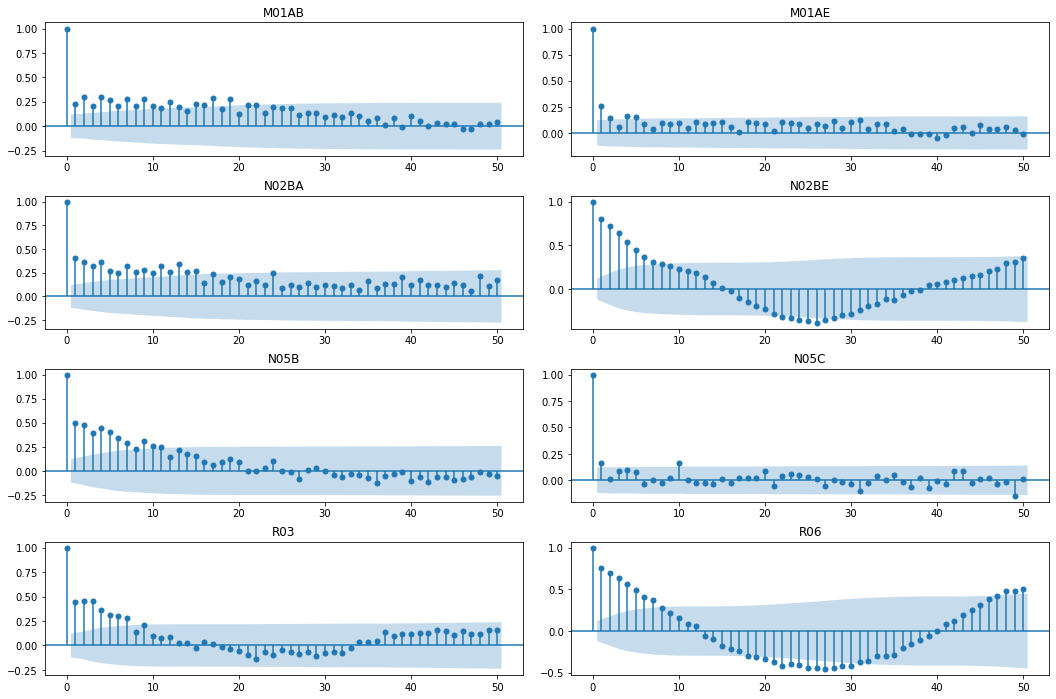

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=50, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

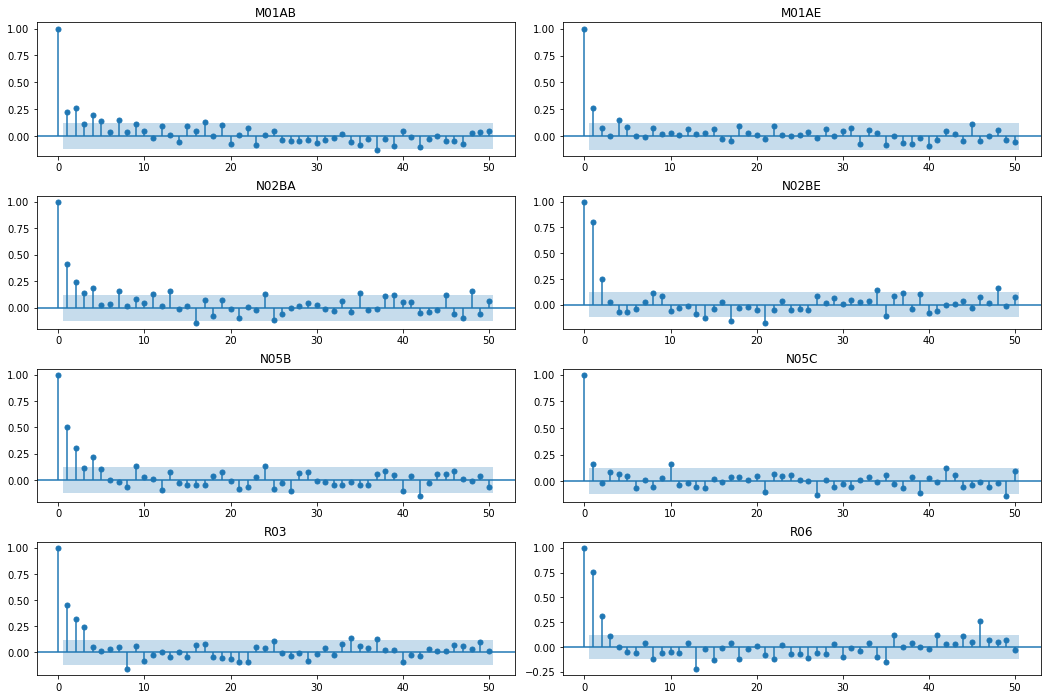

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=50, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

# Forecasting

In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
resultsRolling={x:[0.0]*8 for x in data_w.columns.to_list()}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE', 
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE']

resultsLongterm={x:[0.0]*12 for x in data_w.columns.to_list()}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE', 
                           'AutoARIMA MSE', 'AutoARIMA MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

## Naive Forecasting

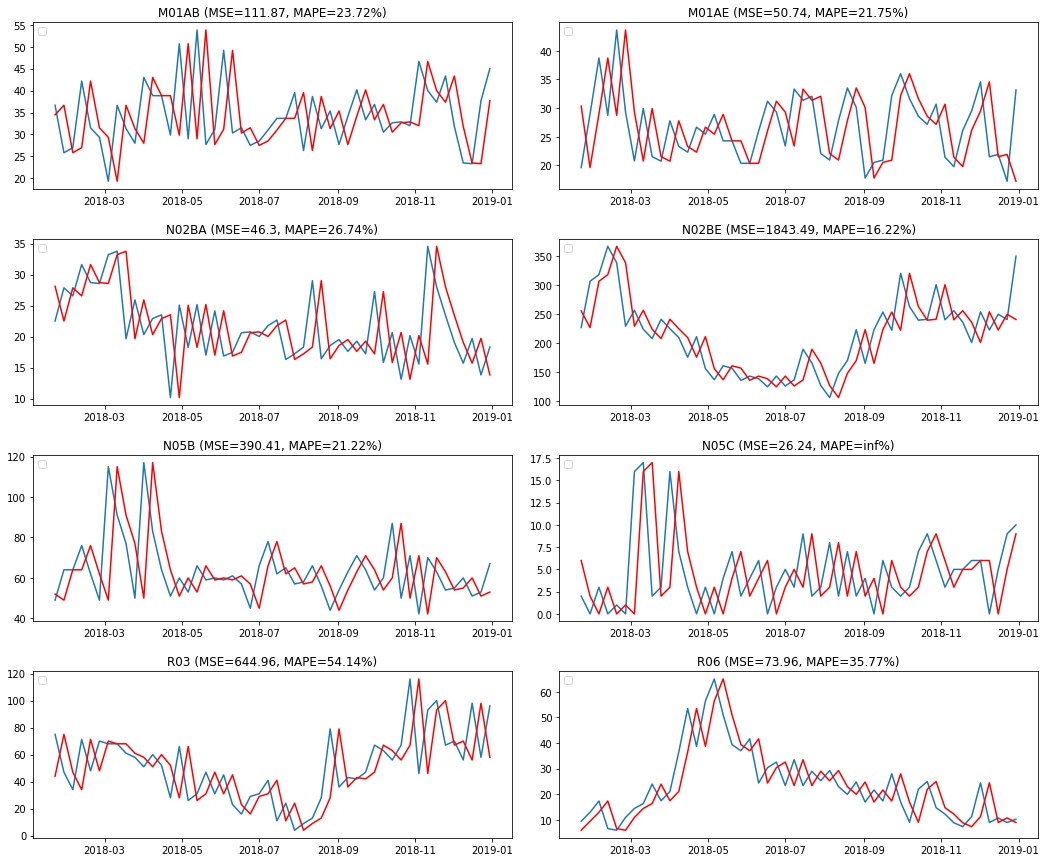

In [10]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = pd.concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

## Seasonal Naive Forecasting

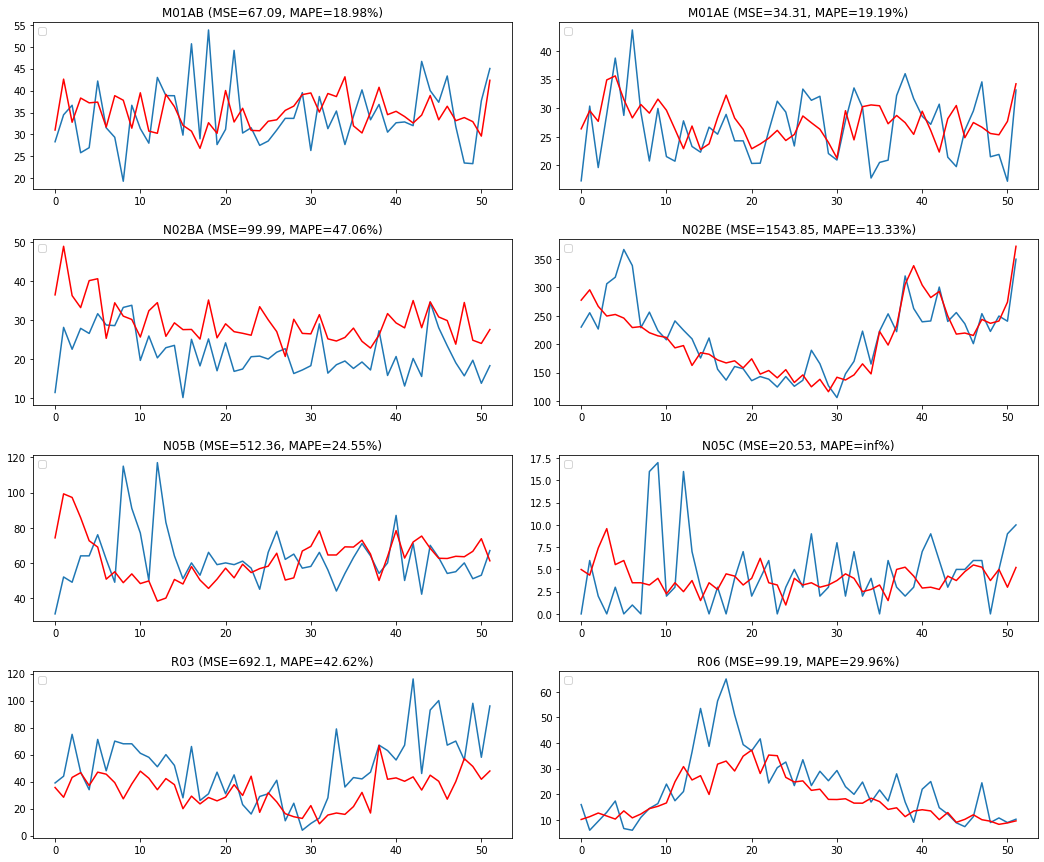

In [11]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

## Average method Forecasting

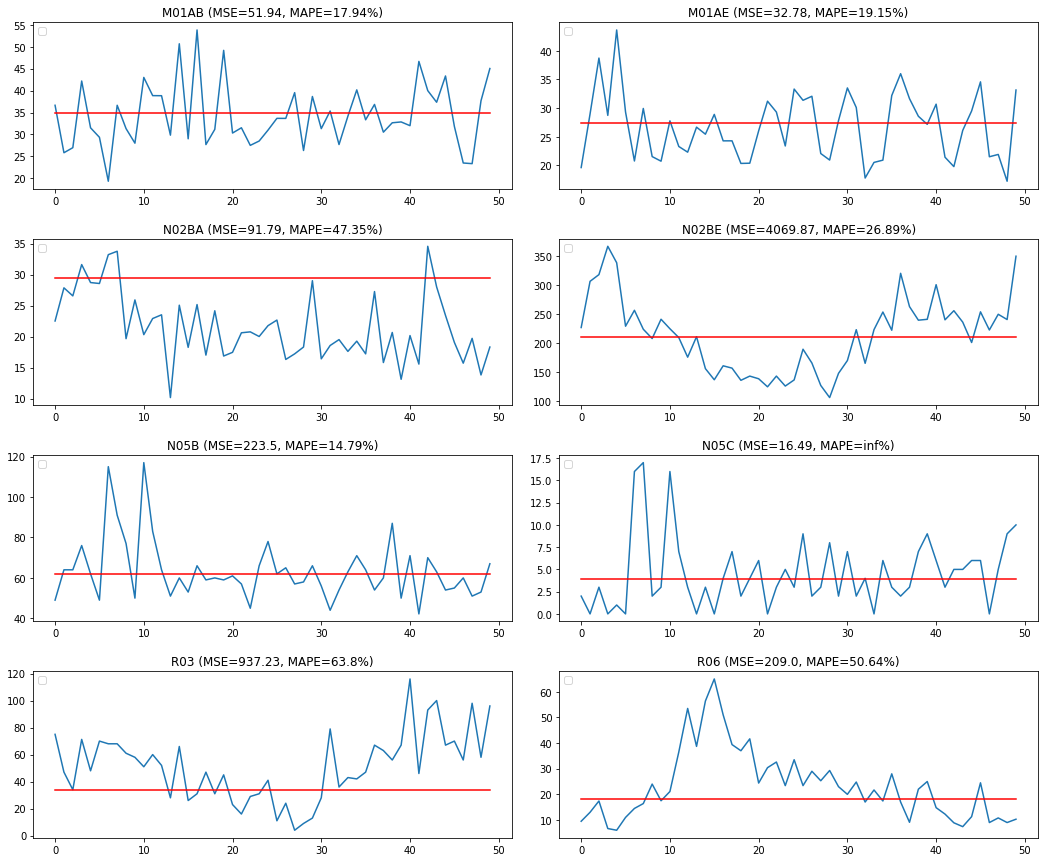

In [12]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)] 
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

## ARIMA Forecasting

### Grid Search ARMA model hyperparameters

In [13]:
import statsmodels.api as sm

warnings.filterwarnings('ignore')

for x in ['M01AB','M01AE','N02BA','N02BE', 'N05B','N05C','R03','R06']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,M01AB) = (4, 4) is the best.
ARMA(p,q,M01AE) = (1, 2) is the best.
ARMA(p,q,N02BA) = (5, 4) is the best.
ARMA(p,q,N02BE) = (5, 4) is the best.
ARMA(p,q,N05B) = (5, 3) is the best.
ARMA(p,q,N05C) = (2, 3) is the best.
ARMA(p,q,R03) = (5, 2) is the best.
ARMA(p,q,R06) = (2, 2) is the best.


However, AIC is not used to score accuracy of the forecasting methods in this research. Mean squared error is used instead. For that, reason, grid search optimization method was applied, where different combinations of the hyper-parameters were used to calculate MSE and then, the combination producing the least MSE was chosen as optimal. Grid search optimization is carried out for both approaches in forecasting: rolling and long-term.

### Grid Search ARIMA model hyperparameters, Rolling Forecast

In [14]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0, n_jobs=-1)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error


def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)



for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMA(0, 0, 0) MSE=54.966
M01AE - Best ARIMA(0, 0, 0) MSE=31.543
N02BA - Best ARIMA(0, 1, 1) MSE=34.011
N02BE - Best ARIMA(2, 0, 0) MSE=1571.963
N05B - Best ARIMA(4, 0, 2) MSE=187.913
N05C - Best ARIMA(0, 0, 1) MSE=13.899
R03 - Best ARIMA(3, 1, 1) MSE=361.712
R06 - Best ARIMA(1, 0, 1) MSE=64.577


### ARIMA Rolling Forecast

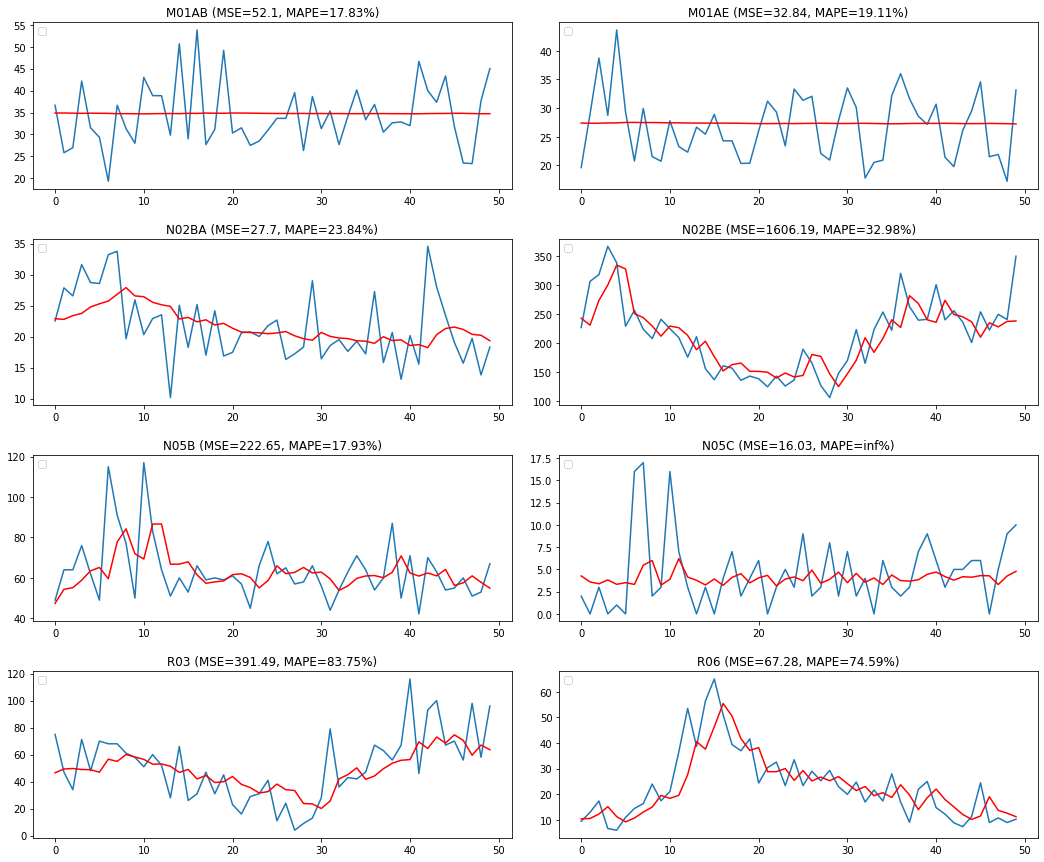

In [26]:
M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':0,'d':0,'q':0}
N02BA= {'series':'N02BA','p':0,'d':1,'q':1}
N02BE= {'series':'N02BE','p':2,'d':0,'q':0}
N05B= {'series':'N05B','p':4,'d':0,'q':2}
N05C= {'series':'N05C','p':0,'d':0,'q':1}
R03= {'series':'R03','p':3,'d':1,'q':1}
R06= {'series':'R06','p':1,'d':0,'q':1}

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(x['p'],x['d'],x['q']))
        model_fit = model.fit(disp=0, n_job=-1)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['ARIMA MSE',x['series']]=error
    resultsRollingdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### Grid Search ARIMA model hyperparameters, Long Term Forecast

In [27]:
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) - 50)
    train, test = X[0:train_size], X[train_size:]
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit(n_jobs=-1)
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

for f in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

M01AB - Best ARIMA(0, 0, 0) MSE=51.937
M01AE - Best ARIMA(0, 0, 0) MSE=32.778
N02BA - Best ARIMA(0, 0, 0) MSE=91.789
N02BE - Best ARIMA(0, 0, 1) MSE=3207.161
N05B - Best ARIMA(0, 0, 0) MSE=223.503
N05C - Best ARIMA(5, 0, 0) MSE=14.944
R03 - Best ARIMA(0, 0, 0) MSE=937.227
R06 - Best ARIMA(4, 0, 5) MSE=157.339


### ARIMA Long Term Forecast

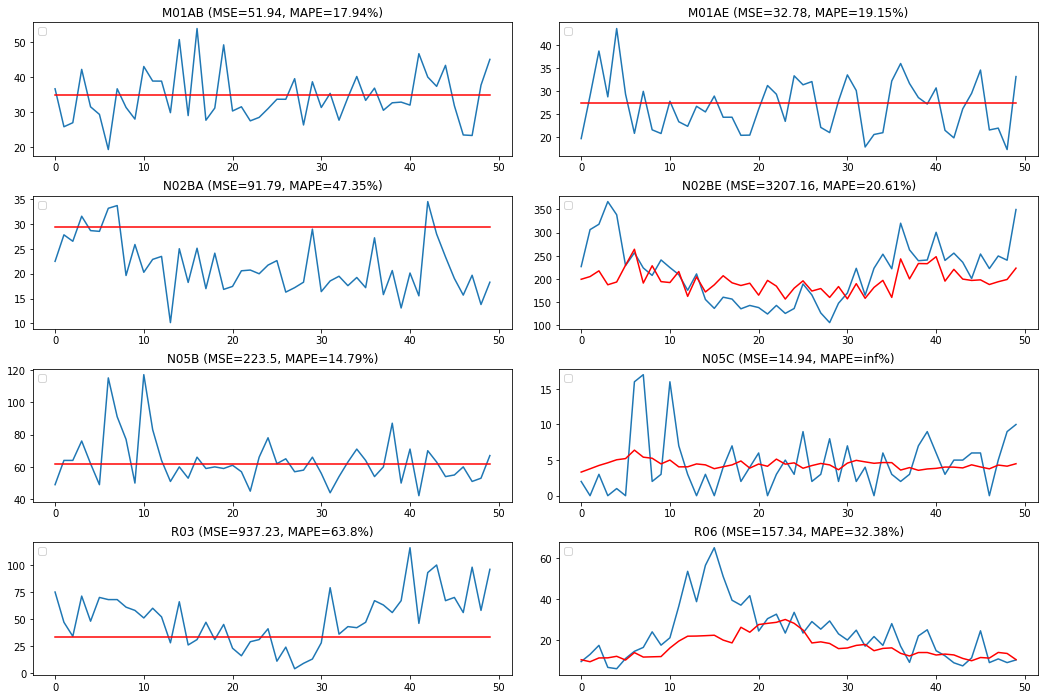

In [28]:
M01AB= {'series':'M01AB','p':0,'d':0,'q':0}
M01AE= {'series':'M01AE','p':0,'d':0,'q':0}
N02BA= {'series':'N02BA','p':0,'d':0,'q':0}
N02BE= {'series':'N02BE','p':0,'d':0,'q':1}
N05B= {'series':'N05B','p':0,'d':0,'q':0}
N05C= {'series':'N05C','p':5,'d':0,'q':0}
R03= {'series':'R03','p':0,'d':0,'q':0}
R06= {'series':'R06','p':4,'d':0,'q':5}

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in [M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06]:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x['series']].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    model = ARIMA(train, order=(x['p'],x['d'],x['q']))
    model_fit = model.fit(n_jobs=-1)
    forecast = model_fit.predict(1,len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, forecast)
    resultsLongtermdf.loc['ARIMA MSE',x['series']]=error
    resultsLongtermdf.loc['ARIMA MAPE',x['series']]=perror
    ax[rowindex,colindex].set_title(x['series']+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

### Auto-ARIMA, Rolling Forecast

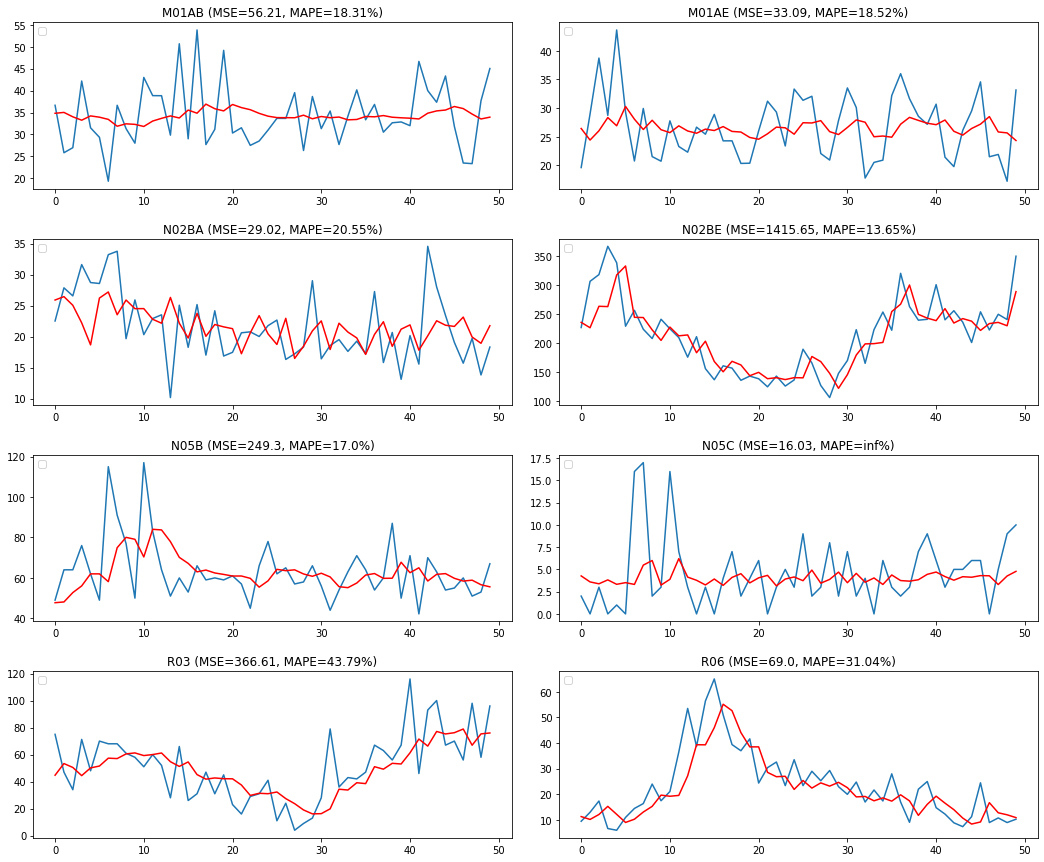

In [18]:
from pmdarima import auto_arima

subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = len(X)-50
    train, test = X[0:size], X[size:len(X)]
    history = [c for c in train]
    predictions = list()
    for t in range(len(test)):
        if (x=='N02BA' or x=='N02BE' or x=='R03' or x=='R06'):
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
        else:
            model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
        model_fit = model.fit(history)
        output = model_fit.predict(n_periods=1)
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['AutoARIMA MSE',x]=error
    resultsRollingdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### Auto-ARIMA, Long-Term Forecasting

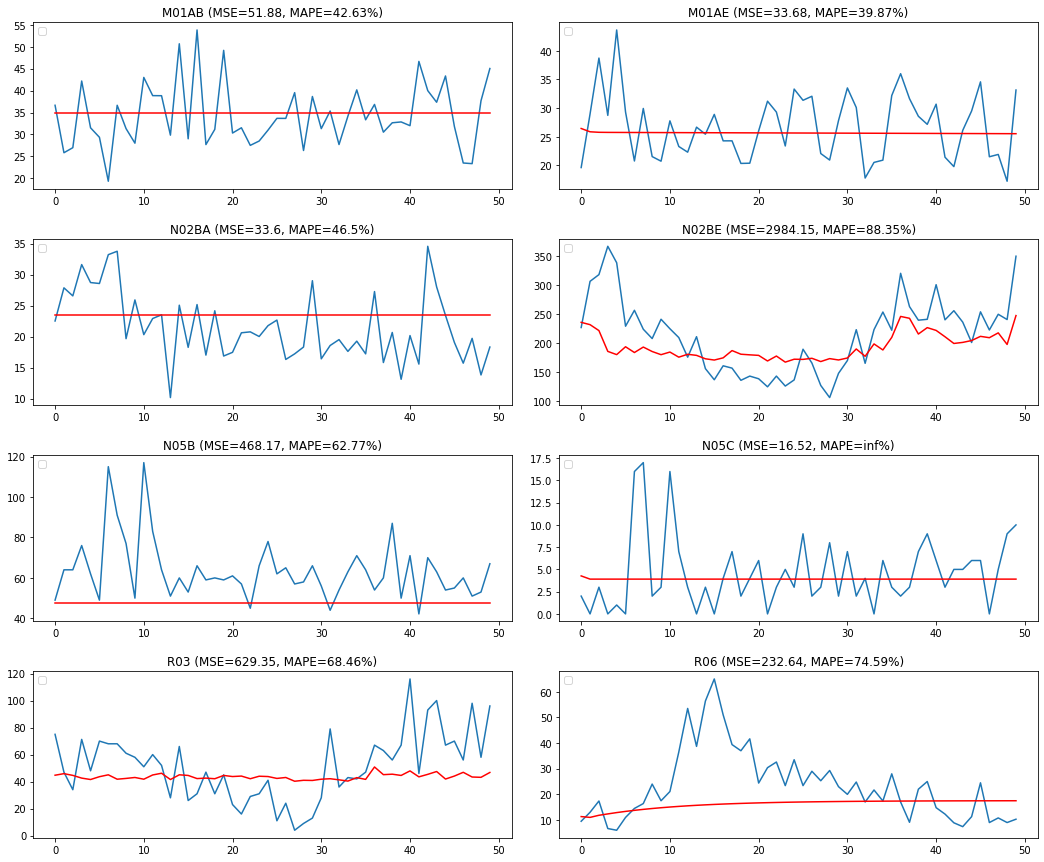

In [31]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X = df[x].values
    size = int(len(X) - 50)
    train, test = X[0:size], X[size:len(X)]
    if (x=='N02BE' or x=='R03' or x=='R06'):
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, m=52, max_d=1, max_D=1,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, seasonal=True,
                           trace=False,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    else:
        model = auto_arima(X, start_p=1, start_q=1,
                           max_p=5, max_q=5, max_d=1,
                           trace=False, seasonal=False,
                           error_action='ignore',
                           suppress_warnings=True, 
                           stepwise=True)
    model_fit = model.fit(train)
    forecast = model_fit.predict(n_periods=len(test))
    error = mean_squared_error(test, forecast)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['AutoARIMA MSE',x]=error
    resultsLongtermdf.loc['AutoARIMA MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(forecast, color='red')
    subplotindex=subplotindex+1
plt.show()

## LSTM Forecasting

In [19]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler

In [20]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

### Vanilla LSTM, Long Term Forecasting

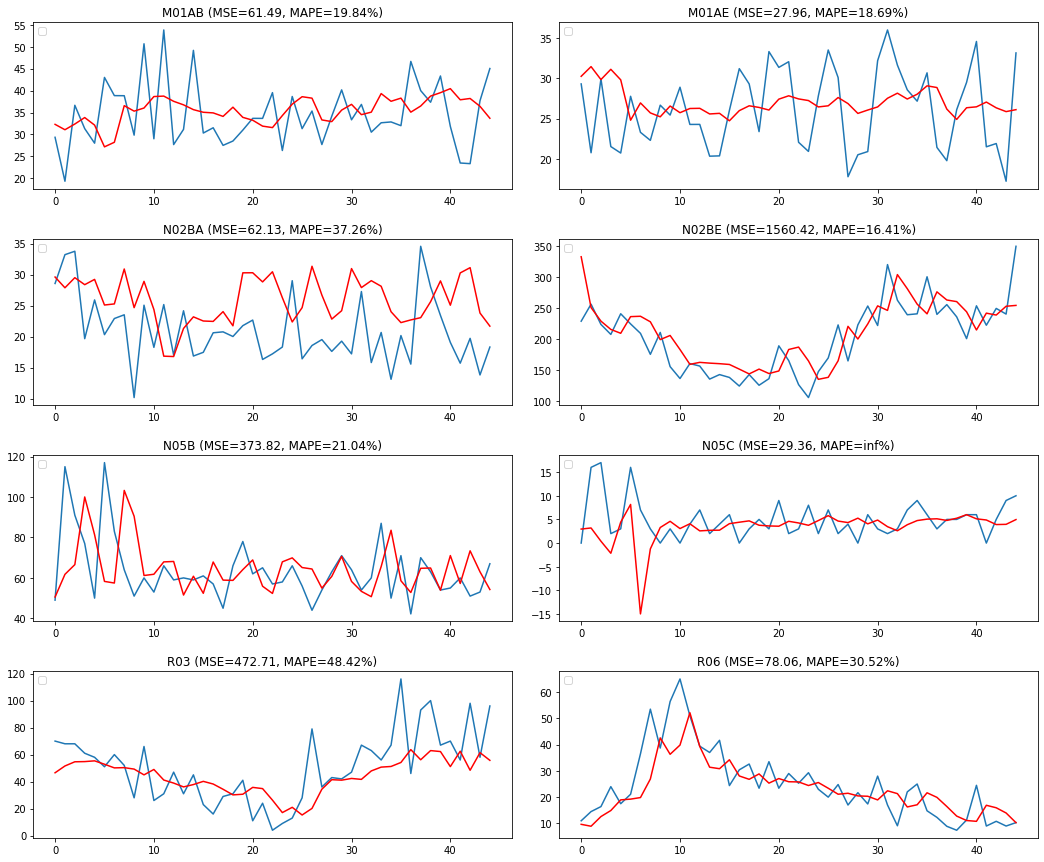

In [21]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Vanilla LSTM MSE',x]=error
    resultsLongtermdf.loc['Vanilla LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### Stacked LSTM, Long Term Forecasting

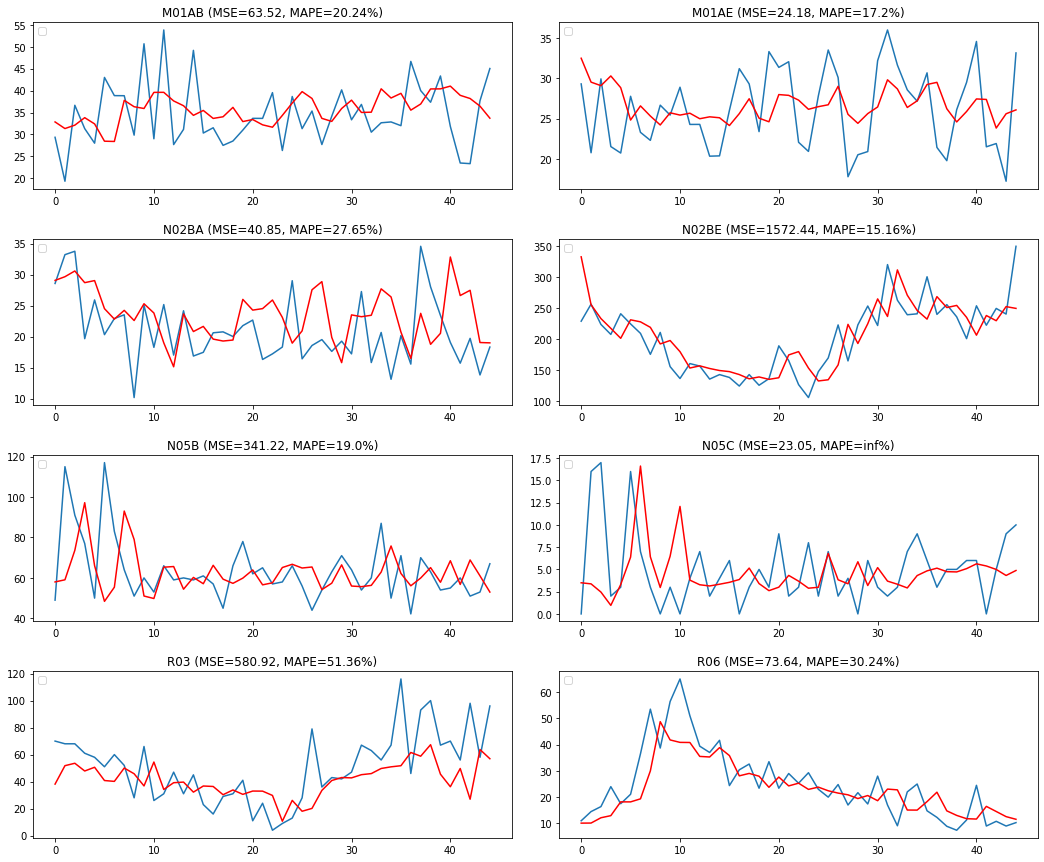

In [22]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Stacked LSTM MSE',x]=error
    resultsLongtermdf.loc['Stacked LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

### Bi-directional LSTM, Long Term Forecasting

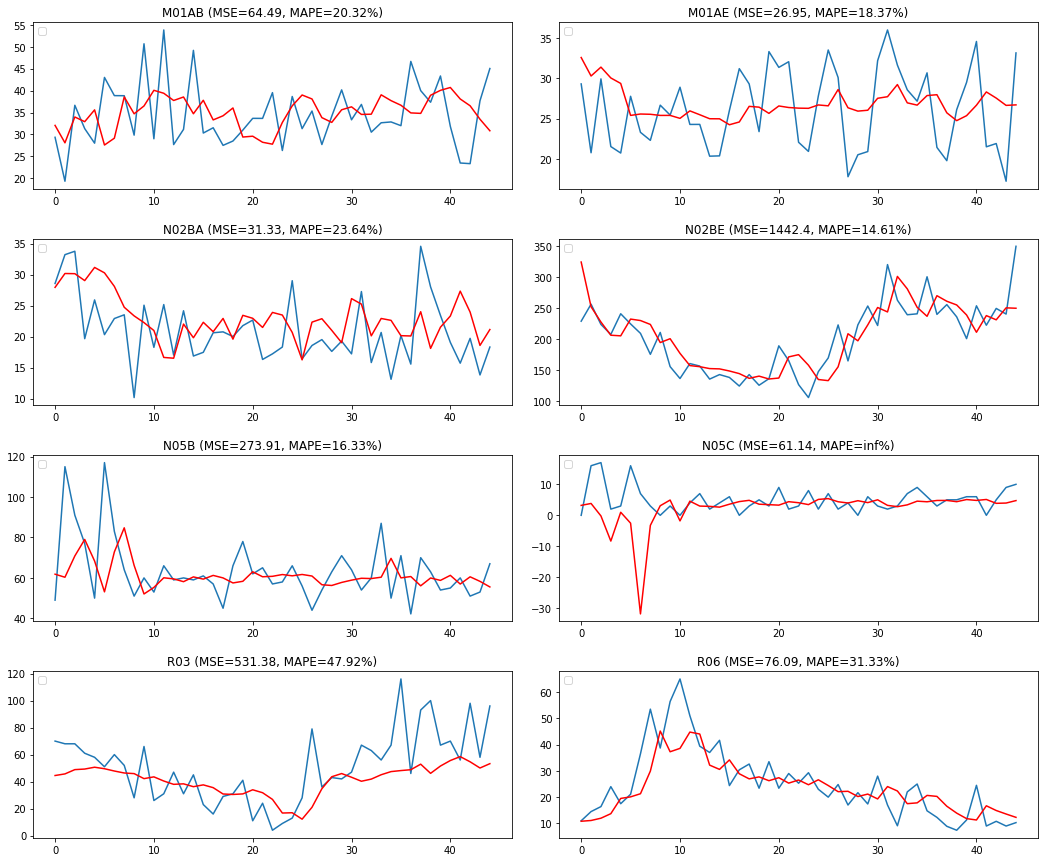

In [23]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

for x in ['M01AB','M01AE','N02BA','N02BE','N05B','N05C','R03','R06']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Bidirectional LSTM MSE',x]=error
    resultsLongtermdf.loc['Bidirectional LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

In [36]:
resultsRollingdf

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
Naive MSE,111.868846,50.743249,46.299100,1843.488986,390.405600,26.240000,644.962500,73.956808
Naive MAPE,23.722123,21.746886,26.739927,16.222279,21.217766,inf,54.143970,35.773904
Seasonal Naive MSE,67.085255,34.311060,99.986681,1543.847176,512.364164,20.532725,692.104436,99.188351
Seasonal Naive MAPE,18.982777,19.192377,47.063939,13.327509,24.547989,inf,42.616002,29.963530
ARIMA MSE,52.100656,32.840690,27.702844,1606.190436,222.654760,16.026584,391.488919,67.280818
ARIMA MAPE,17.834869,19.114444,23.838227,32.983417,17.930573,inf,83.751781,74.593463
AutoARIMA MSE,56.206617,33.090147,29.021428,1415.645809,249.299946,16.026589,366.614776,69.003115
AutoARIMA MAPE,18.309534,18.519607,20.547315,13.646422,17.003129,inf,43.789457,31.035593


In [33]:
resultsLongtermdf

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
Average MSE,51.936806,32.778027,91.788566,4069.873210,223.502695,16.492828,937.226799,208.997014
Average MAPE,17.940486,19.147786,47.351619,26.893716,14.791244,inf,63.795526,50.639135
ARIMA MSE,51.936806,32.778027,91.788566,3207.160722,223.502695,14.943884,937.226799,157.338510
ARIMA MAPE,17.940486,19.147786,47.351619,20.607463,14.791244,inf,63.795526,32.380241
AutoARIMA MSE,51.877096,33.676967,33.599633,2984.147309,468.168012,16.524149,629.350545,232.643595
AutoARIMA MAPE,42.629644,39.866391,46.502512,88.351504,62.765480,inf,68.463003,74.593463
Vanilla LSTM MSE,61.493617,27.959009,62.133163,1560.420705,373.824267,29.356321,472.706152,78.060296
Vanilla LSTM MAPE,19.838783,18.691615,37.255056,16.413307,21.039727,inf,48.417294,30.524785
Stacked LSTM MSE,63.518252,24.183801,40.847950,1572.442689,341.221685,23.052885,580.921883,73.639114
Stacked LSTM MAPE,20.239260,17.199913,27.647506,15.160362,19.001697,inf,51.355923,30.238040
